## Dataset Selection

Select a dataset identically to the way you selected for lab one or lab three (table data or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains three or more classes to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

## Grading Rubric

### Preparation (15 points total)
[5 points] (mostly the same processes as from lab four) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?

[10 points] (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

### Evaluation (30 points total)
[15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

Important: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be regarded as a conceptual error and graded accordingly. 
### Modeling (45 points total)
[20 points] Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
When instantiated, use a selectable nonlinearity function for the first layer: either sigmoid or linear 
Use a selectable cost function when instantiated: either quadratic or cross entropy

[15 points] Tune the hyper-parameters of your MLP model (at least two hyper-parameters). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. Visualize the evaluation metric(s) versus the hyper-parameters. Conclude what combination of parameters are best.

[10 points] Compare the performance of your MLP training procedure to scikit-learn. Which implementation is better in terms of generalization performance, computation time, and memory used while training?

### Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea: Add support for more than one hidden layer or a different nonlinear activation (i.e., softmax, tanh). Please note that different activation functions might require different weight initializations to work well. 

In [9]:
import os
import sys
import random
import copy
import warnings
from random import randint
import _pickle as cPickle

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.neural_network import MLPClassifier
from scipy.misc import imread
from scipy.special import expit
import pywt # conda install -c conda-forge pywavelets
from skimage.filters import roberts
from skimage.feature import daisy
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score

%matplotlib inline
%load_ext memory_profiler
plt.style.use('ggplot')

In [5]:
# a helper plotting function
def plot_gallery(imgs, labels, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(imgs[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(labels[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [6]:
###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./imgs/
###

def get_images(): # stuck this in a function to clean up memory 
    dics = []
    for root, directory, files in os.walk('imgs'):
        for f in files:
            if 'data_batch' in f or 'test_batch' in f:
                with open(root+'/'+f, 'rb') as fo:
                    dics.append(cPickle.load(fo, encoding='latin1'))

    img_color = []
    img_labels = []
    for dic in dics:
        for i in range(len(dic['data'])):
            img_color.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
            img_labels.append(dic['labels'][i]) # int representing the label

    img_color = np.array(img_color)
    img_labels = np.array(img_labels)

    # grab the mapping between label names and IDs
    print('Labels:')
    labels = {}
    with open('./imgs/batches.meta', 'rb') as fo:
        labels_tmp = cPickle.load(fo, encoding='latin1')
        for i in range(len(labels_tmp['label_names'])):
            labels[i] = labels_tmp['label_names'][i]
            print(i, "-->", labels_tmp['label_names'][i])
    print()

    img_label_names = np.array([labels[x] for x in img_labels])

    def toGrayscale(img):
        r, g, b = img[:1024], img[1024:2048], img[2048:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    img_gray = np.array([toGrayscale(x) for x in img_color])
    
    return (img_color, img_gray, img_labels, img_label_names)

img_color, img_gray, img_labels, img_label_names = get_images()
img_gray = img_gray
img_labels = img_labels
print("n_samples: {}".format(len(img_gray)))
print("n_features: {}".format(len(img_gray[0])))
print("n_classes: {}".format(len(np.unique(img_labels))))
print("Original Image Size: {} x {}".format(32, 32))

Labels:
0 --> airplane
1 --> automobile
2 --> bird
3 --> cat
4 --> deer
5 --> dog
6 --> frog
7 --> horse
8 --> ship
9 --> truck

n_samples: 60000
n_features: 1024
n_classes: 10
Original Image Size: 32 x 32


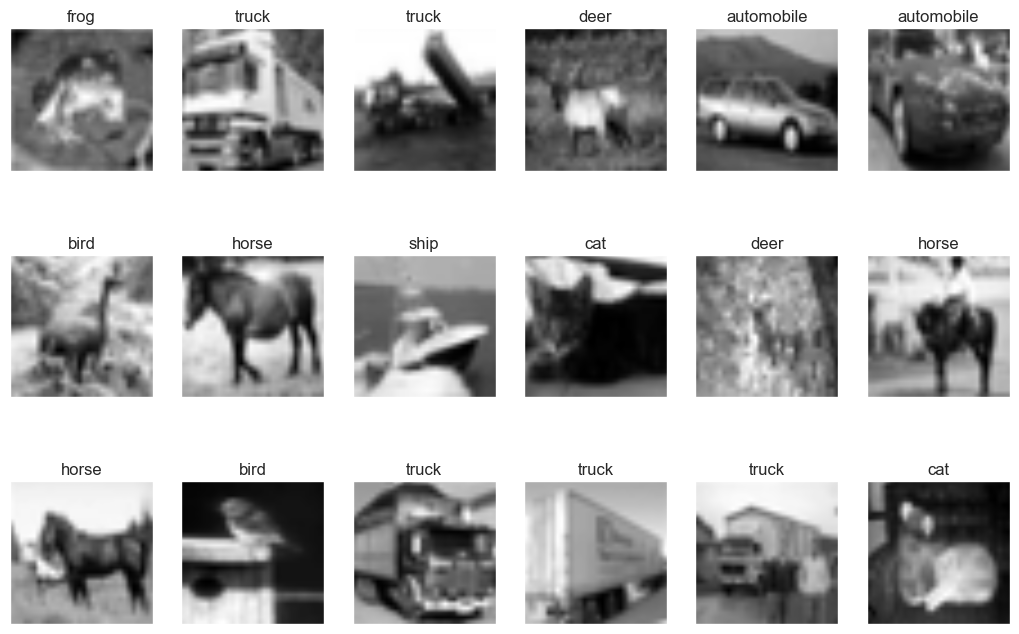

In [7]:
plot_gallery(img_gray, img_label_names, 32, 32) 

In [5]:
def zca_whitening_matrix(inputs):
    #Correlation matrix
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1]

    #Singular Value Decomposition
    U,S,V = np.linalg.svd(sigma)

    #Whitening constant, it prevents division by zero
    epsilon = 0.1

    #ZCA Whitening matrix
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)

    #Data whitening
    return np.dot(ZCAMatrix, inputs)

def global_contrast_normalization(x, s, lmda, epsilon):
    # replacement for the loop
    x = x - np.mean(x)

    # `su` is here the mean, instead of the sum
    contrast = np.sqrt(lmda + np.mean(x**2))

    x = s * x / max(contrast, epsilon)
    return x

# contrast normalization
img_gray = np.array([np.concatenate(global_contrast_normalization(x.reshape((32,32)), 1, 10, .001)) for x in img_gray])

# pca/zca???
#pca = PCA(whiten=True)
#img_pca = pca.fit_transform(img_gray)


In [ ]:
# http://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html
img_gray = [np.concatenate(roberts(x.reshape((32,32)))) for x in img_gray] 
plot_gallery(img_gray, img_label_names, 32, 32) 

In [ ]:
# https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#single-level-dwt2
for i in range(len(img_gray)):
    res = pywt.dwt2(img_gray[i].reshape((32,32)), 'haar')
    img_gray[i] = np.concatenate(np.vstack([np.hstack([res[0], res[1][0]]), np.hstack([res[1][1], res[1][2]])]))
plot_gallery(img_gray, img_label_names, 32, 32) 

In [8]:
daisies = np.array([np.concatenate(np.concatenate(daisy(x.reshape((32,32)), step=16, radius=7, rings=2, histograms=8, orientations=5))) for x in img_gray])

(60000, 340)

In [ ]:
# OTHER IDEAS FOR IMAGE PROCESSING: https://www.quora.com/What-are-some-simple-machine-learning-algorithms-for-image-classification

## Modeling

In [10]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 first_func="sigmoid", cost_func="cross entropy"):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.first_func = first_func
        self.cost_func = cost_func
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights"""
        if self.first_func == "relu":
            init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
            W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))

            init_bound = np.sqrt(2. / (self.n_output_ + self.n_hidden + 1))
            W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        else: 
            W1_num_elems = (self.n_features_ + 1)*self.n_hidden
            W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
            W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W

            W2_num_elems = (self.n_hidden + 1)*self.n_output_
            W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
            W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        if self.cost_func == "cross entropy":
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        else: # quadratic
            cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if self.first_func == "sigmoid":
            A2 = self._sigmoid(Z1)
        elif self.first_func == "relu":
            A2 = self._relu(Z1)
        else: 
            A2 = Z1
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        
        # vectorized backpropagation
        if self.cost_func == "cross entropy":
            sigma3 = (A3-Y_enc)
        else: # quadratic
            sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
        
        if self.first_func == "sigmoid":
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        elif self.first_func == "relu":
            sigma2 = (W2.T @ sigma3) 
            Z1_with_bias = self._add_bias_unit(Z1,how='row')
            sigma2[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        else: # linear
            sigma2 = (W2.T @ sigma3)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    def score(self, x, y):
        res = self.predict(x)
        return f1_score(y, res, average='macro')
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
            
    def get_params(self, deep=True):
        return {
            'eta': self.eta,
            'n_hidden': self.n_hidden,
            'C': self.l2_C,
            'epochs': self.epochs,
            'eta': self.eta,
            'first_func': self.first_func,
            'cost_func': self.cost_func
        }

In [11]:
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(f1_score(y_data,self.predict(X_data), average='macro'))
            
        return self

#check_estimator(TLPMiniBatch)

In [12]:
x = daisies
y = img_labels

In [13]:
## Gridsearch 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
params = {
    "n_hidden": [50],
    "eta": [.0001, .001, .1],
    "epochs": [200],
    "C": [0.0, .5, .2],
    "first_func": ('sigmoid', 'linear', 'relu'),
    "cost_func": ('quadratic', 'cross entropy'),
}


cv = GridSearchCV(TLPMiniBatch(), params, n_jobs=-1) # runs in parallel to get the job done as quick as possible
%time %memit cv.fit(X_train, y_train)
print('Best score: '+str(cv.best_score_))
y_hat = cv.predict(X_test)

NameError: name 'X_train' is not defined

In [18]:
params =  dict(n_hidden=100, 
              C=0.0001, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              cost_func="cross entropy",
              first_func="sigmoid")
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', TLPMiniBatch(**params))])
# %time %memit for train_index, test_index in cv.split(x, y):
#     pl.fit(x[train_index], y[train_index])
#     yhat = pl.predict(x[test_index])
#     print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
#     print(np.bincount(yhat))

In [ ]:
## Gridsearch 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
params = {
    "n_hidden": [50],
    "eta": [.0001, .001, .1],
    "epochs": [200],
    "C": [0.0, .5, .2],
    "first_func": ('sigmoid', 'linear', 'relu'),
    "cost_func": ('quadratic', 'cross entropy'),
}


gs = GridSearchCV(TLPMiniBatch(), params, n_jobs=-1) # runs in parallel to get the job done as quick as possible
# %time %memit cv.fit(X_train, y_train)
# print('Best score: '+str(cv.best_score_))
# y_hat = cv.predict(X_test)

 
for train_index, test_index in cv.split(x, y):
    %time %memit gs.fit(x[train_index], y[train_index])
    yhat = gs.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics as mt

conf = mt.confusion_matrix(y_test, y_hat)
print("Confusion matrix\n",conf)
print(cv.best_params_)


In [ ]:
# SKLearn's implementation
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', MLPClassifier())])
%time %memit for train_index, test_index in cv.split(x, y):
    pl.fit(x[train_index], y[train_index])
    yhat = pl.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))